In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import glob 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import matplotlib.ticker as mticker
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import scipy as sp
from scipy.stats import linregress
import sklearn.linear_model as LR
import scipy.stats as stats
import cmasher as cmr

import pandas as pd

In [2]:
SEAS = 'ANN'

In [3]:
seasons = {"ANN": np.arange(1,13,1),
            "DJF": [12, 1, 2],
            "JJA": [6, 7, 8],
            "MAM": [3, 4, 5],
            "SON": [9, 10, 11]
            }
DTDT = pd.date_range(start='1980-01-01',end='1980-12-01',freq='1MS')
# Create a DataFrame to hold the date range
df = pd.DataFrame({'date': DTDT})

# Extract the number of days in each month
df['days_in_month'] = df['date'].dt.days_in_month
df['month'] = df['date'].dt.month
df

,date,days_in_month,month
0,1980-01-01,31,1
1,1980-02-01,29,2
2,1980-03-01,31,3
3,1980-04-01,30,4
4,1980-05-01,31,5
5,1980-06-01,30,6
6,1980-07-01,31,7
7,1980-08-01,31,8
8,1980-09-01,30,9
9,1980-10-01,31,10


In [4]:
def seas_mean(DS, df, season):
    DSdo = DS.sel(time=DS.time.isin(seasons[season]))

    if np.isin(season,['DJF','MAM','SON','JJA']):
        m1w=df[df['month']==DSdo.time[0].values]['days_in_month'].values[0]
        m2w=df[df['month']==DSdo.time[1].values]['days_in_month'].values[0]
        m3w=df[df['month']==DSdo.time[2].values]['days_in_month'].values[0]
        weights = np.array([m1w,m2w,m3w])
    if season =='ANN':
        m1w=df[df['month']==DSdo.time[0].values]['days_in_month'].values[0]
        m2w=df[df['month']==DSdo.time[1].values]['days_in_month'].values[0]
        m3w=df[df['month']==DSdo.time[2].values]['days_in_month'].values[0]
        m4w=df[df['month']==DSdo.time[3].values]['days_in_month'].values[0]
        m5w=df[df['month']==DSdo.time[4].values]['days_in_month'].values[0]
        m6w=df[df['month']==DSdo.time[5].values]['days_in_month'].values[0]
        m7w=df[df['month']==DSdo.time[6].values]['days_in_month'].values[0]
        m8w=df[df['month']==DSdo.time[7].values]['days_in_month'].values[0]
        m9w=df[df['month']==DSdo.time[8].values]['days_in_month'].values[0]
        m10w=df[df['month']==DSdo.time[9].values]['days_in_month'].values[0]
        m11w=df[df['month']==DSdo.time[10].values]['days_in_month'].values[0]
        m12w=df[df['month']==DSdo.time[11].values]['days_in_month'].values[0]
        weights = np.array([m1w,m2w,m3w,m4w,m5w,m6w,m7w,m8w,m9w,m10w,m11w,m12w])
        
    weights = weights/weights.sum()
    ds_weighted = (DSdo*np.expand_dims(np.expand_dims(weights,1),1))
    DSseas = ds_weighted.sum(dim='time')

    return DSseas.load()

def wgt_rmse(fld1, fld2, wgt):
    """Calculate the area-weighted RMSE.

    Parameters
    ----------
    fld1, fld2 : array-like
        2-dimensional spatial fields with the same shape.
        They can be xarray DataArray or numpy arrays.
    wgt : array-like
        the weight vector, expected to be 1-dimensional,
        matching length of one dimension of the data.

    Returns
    -------
    float
        root mean squared error

    Notes:
    ```rmse = sqrt( mean( (fld1 - fld2)**2 ) )```
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.sum(warray * (fld1 - fld2)**2)
        return np.sqrt( wmse ).item()

In [5]:
DSsuper5 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/CAM5_Betzy1/climo/CAM5_Betzy1_U10_climo.nc')
DSsuper5_season = seas_mean(DSsuper5,df,SEAS)

DSmme = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/MME_Regular/climo/MME_Regular_U10_climo.nc')
DSMME_Season = seas_mean(DSmme,df,SEAS)

DSc5 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/FHIST5_f09_g16_v2/climo/FHIST5_f09_g16_v2_U10_climo.nc')
DSCAM5_Season = seas_mean(DSc5,df,SEAS)

DSsuper6 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/CAM6_Betzy1/climo/CAM6_Betzy1_U10_climo.nc')
DSsuper6_season = seas_mean(DSsuper6,df,SEAS)

DSc6 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/FHIST_f09_g16/climo/FHIST_f09_g16_U10_climo.nc')
DSCAM6_season = seas_mean(DSc6,df,SEAS)

DSmmer = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/MME_Combined/climo/MME_Combined_U10_climo.nc')
DSMMEr_season = seas_mean(DSmmer,df,SEAS)

DSobs = xr.open_dataset('/glade/work/wchapman/ADF_obs_Mar2024/ERA5_time_u10_climo_1979_2010.nc')
DSobs_season = seas_mean(DSobs,df,SEAS)

## Keep:

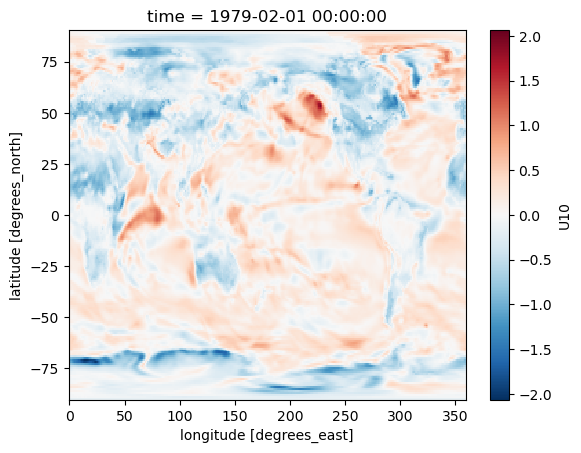

conclusion: the ADF files are not the same


In [6]:
DStr = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/CAM5_Betzy1/ts/CAM5_Betzy1.cam.h0.U10.197901-200512.nc')
DStr3 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/MME_Combined/ts/MME_Combined.cam.h0.U10.197901-200512.nc')
(DStr-DStr3).isel(time=0)['U10'].plot()
plt.show()
print('conclusion: the ADF files are not the same')

## Difference in Climo

In [36]:
clevs = np.arange(-1.0, 1.1, .1)
# bluey = mpl.cm.get_cmap('RdGy', len(clevs))
bluey = plt.get_cmap('cmr.waterlily')   # MPL
newcolors = bluey(np.linspace(0, 1, len(clevs)))
cmapzzz = ListedColormap(newcolors)

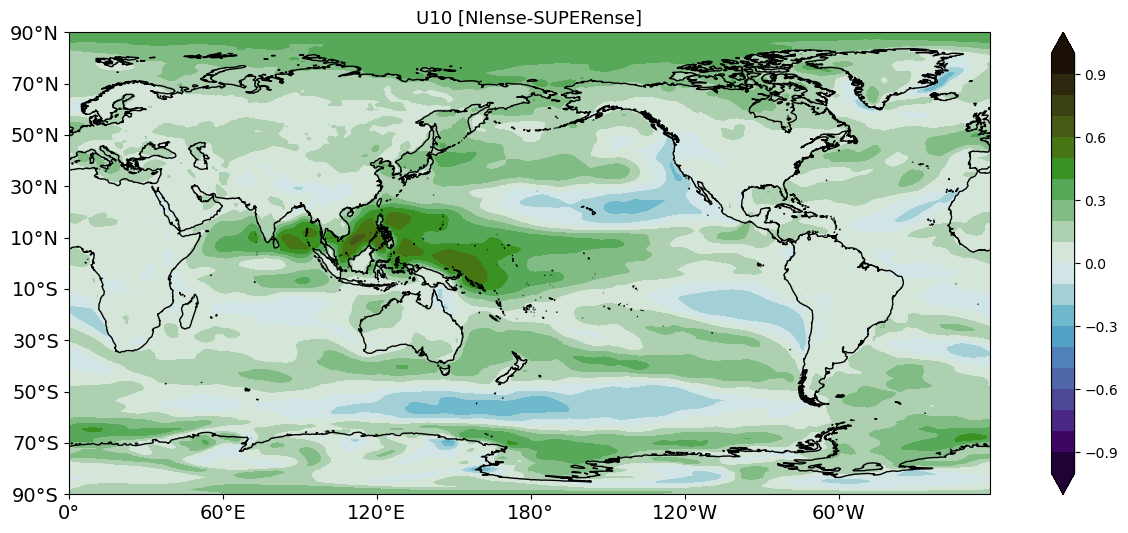

In [37]:
plotter = DSMME_Season['U10']-DSMMEr_season['U10']

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax1 = plt.subplots(1, 1, figsize=(16,6), subplot_kw={'projection': proj}, sharey=True)

lons = DSCAM6_season['lon']
lats = DSCAM6_season['lat']

ax1.coastlines('50m')
f = ax1.contourf(lons-180, lats, plotter, levels = clevs ,cmap = cmapzzz, extend='both', transform=proj)
ax1.set_xticks(np.arange(-180,180,60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax1.xaxis.set_major_formatter(lon_formatter)

ax1.set_yticks(np.arange(-90,100,20))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_title('U10 [NIense-SUPERense]', fontsize=13)
ax1.tick_params(labelsize=14)
plt.colorbar(f)
plt.savefig(f'./{SEAS}_U10_NIense_vs_Super6.png',bbox_inches='tight',dpi=400)
plt.show()


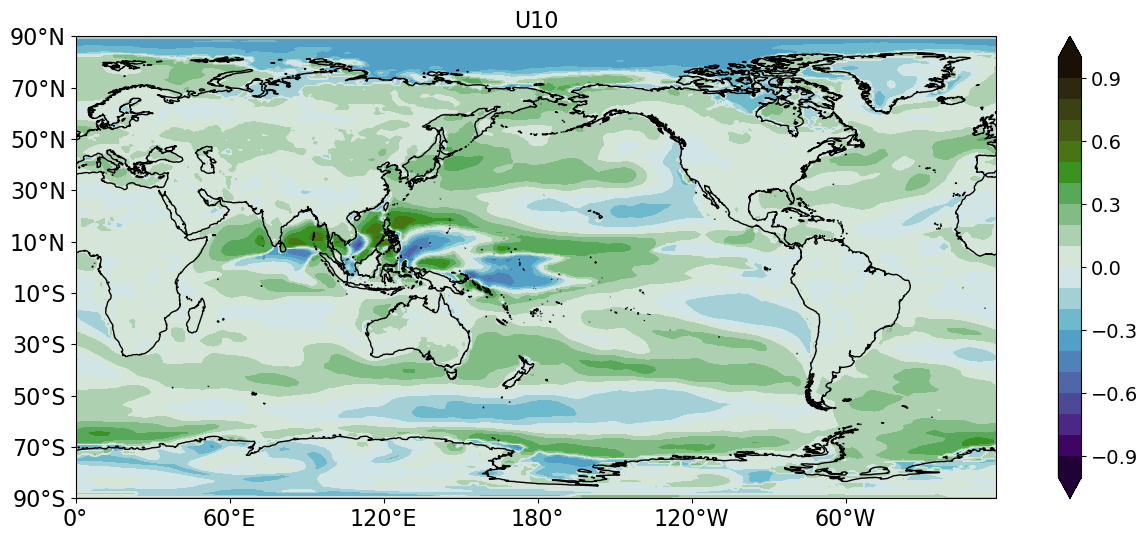

Tropics RMSE Percent: 5.528344629217715
Global RMSE Percent: 4.757437137297363


In [38]:
lat = DSobs_season['lat']
wgt = np.cos(np.radians(lat))

plotter1 = np.abs(DSMME_Season['U10']-DSobs_season['U10'])
plotter2 = np.abs(DSMMEr_season['U10']-DSobs_season['U10'])

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax1 = plt.subplots(1, 1, figsize=(16,6), subplot_kw={'projection': proj}, sharey=True)

lons = DSCAM6_season['lon']
lats = DSCAM6_season['lat']

ax1.coastlines('50m')
f = ax1.contourf(lons-180, lats, plotter1 - plotter2, levels = clevs ,cmap = cmapzzz, extend='both', transform=proj)
ax1.set_xticks(np.arange(-180,180,60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax1.xaxis.set_major_formatter(lon_formatter)

ax1.set_yticks(np.arange(-90,100,20))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_title('U10', fontsize=16)
ax1.tick_params(labelsize=16)
pfp = plt.colorbar(f)
pfp.ax.tick_params(labelsize=14) 
plt.savefig(f'./{SEAS}_U10_NIense-Super6_BiasDiff.png',bbox_inches='tight',dpi=400)
plt.show()

RMSEni = wgt_rmse(DSMME_Season.sel(lat=slice(-30,30))['U10'],DSobs_season.sel(lat=slice(-30,30))['U10'],wgt.sel(lat=slice(-30,30)))
RMSEse = wgt_rmse(DSMMEr_season.sel(lat=slice(-30,30))['U10'],DSobs_season.sel(lat=slice(-30,30))['U10'],wgt.sel(lat=slice(-30,30)))
print(f"Tropics RMSE Percent: {100*((RMSEni-RMSEse)/RMSEni)}")

RMSEni = wgt_rmse(DSMME_Season.sel(lat=slice(-90,90))['U10'],DSobs_season.sel(lat=slice(-90,90))['U10'],wgt.sel(lat=slice(-90,90)))
RMSEse = wgt_rmse(DSMMEr_season.sel(lat=slice(-90,90))['U10'],DSobs_season.sel(lat=slice(-90,90))['U10'],wgt.sel(lat=slice(-90,90)))
print(f"Global RMSE Percent: {100*((RMSEni-RMSEse)/RMSEni)}")

/glade/derecho/scratch/wchapman/tmp/ipykernel_5141/2346603410.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))


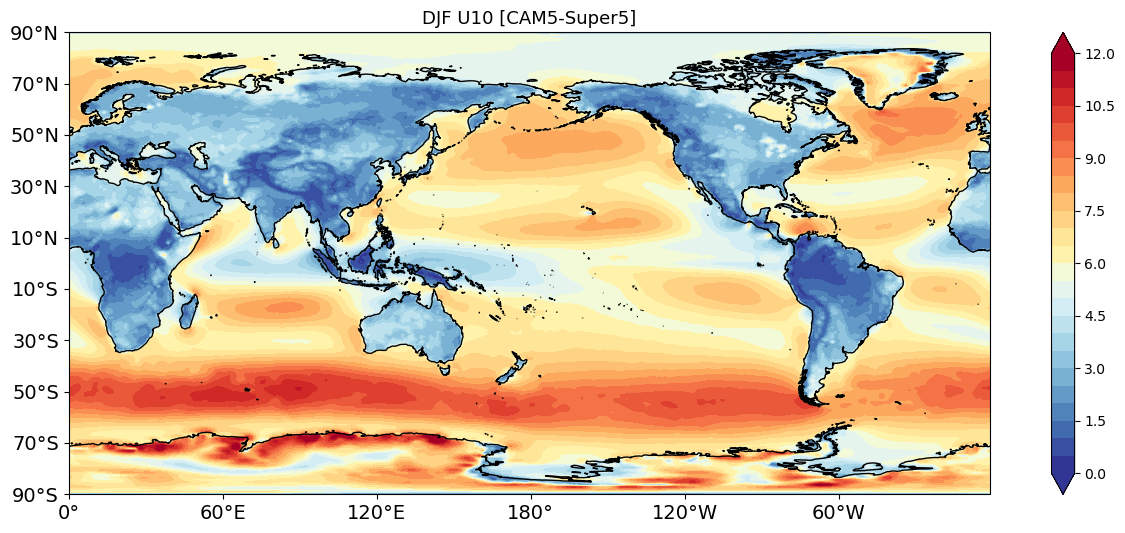

In [11]:
clevs = np.arange(0, 12.5, .5)
bluey = mpl.cm.get_cmap('RdYlBu_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
cmapzzz = ListedColormap(newcolors)

plotter = DSobs_season['U10']

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax1 = plt.subplots(1, 1, figsize=(16,6), subplot_kw={'projection': proj}, sharey=True)

lons = DSCAM6_season['lon']
lats = DSCAM6_season['lat']

ax1.coastlines('50m')
f = ax1.contourf(lons-180, lats, plotter, levels = clevs ,cmap = cmapzzz, extend='both', transform=proj)
ax1.set_xticks(np.arange(-180,180,60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax1.xaxis.set_major_formatter(lon_formatter)

ax1.set_yticks(np.arange(-90,100,20))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_title('DJF U10 [CAM5-Super5]', fontsize=13)
ax1.tick_params(labelsize=14)
plt.colorbar(f)
plt.show()


/glade/derecho/scratch/wchapman/tmp/ipykernel_5141/2944835476.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey = mpl.cm.get_cmap('PuOr_r', len(clevs))
/glade/derecho/scratch/wchapman/tmp/ipykernel_5141/2944835476.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey_obs = mpl.cm.get_cmap('RdYlBu_r', len(clevs_obs))


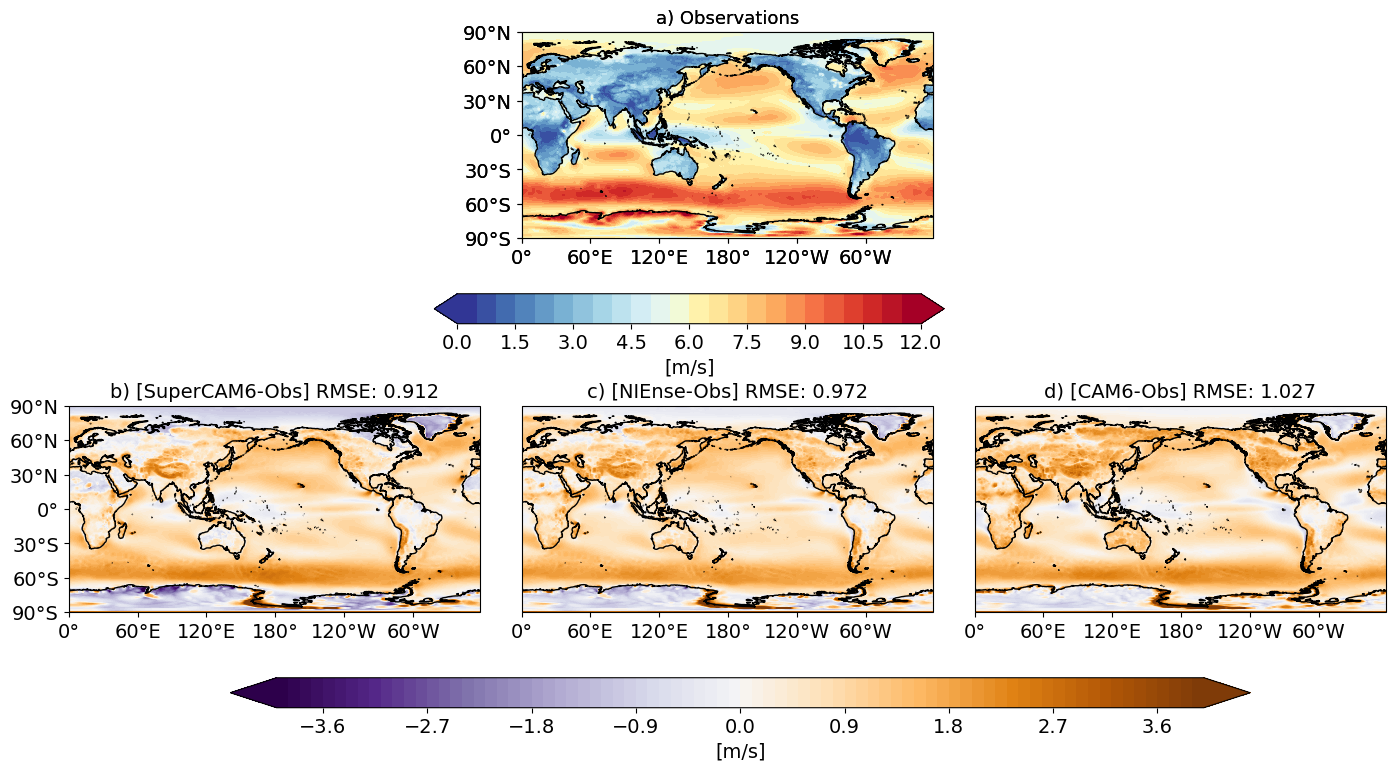

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.gridspec as gridspec

# Assuming DSobs_season, DSCAM6_season, DSsuper5_season, DSMME_Season are already defined datasets

clevs = np.arange(-4, 4.1, .1)
bluey = mpl.cm.get_cmap('PuOr_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
cmapzzz = ListedColormap(newcolors)

clevs_obs = np.arange(-0, 12.5, .5)
bluey_obs = mpl.cm.get_cmap('RdYlBu_r', len(clevs_obs))
newcolors_obs = bluey_obs(np.linspace(0, 1, len(clevs_obs)))
cmapzzz_obs = ListedColormap(newcolors_obs)
proj = ccrs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(17, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 2], width_ratios=[1, 1, 1], wspace=0.1, hspace=-.32)

# Top middle panel for observations
ax_top = fig.add_subplot(gs[0, 1], projection=proj)
plotter_obs = DSobs_season['U10']

lat = DSobs_season['lat']
wgt = np.cos(np.radians(lat))

ax_top.coastlines('50m')
f_obs = ax_top.contourf(lons - 180, lats, plotter_obs, levels=clevs_obs, cmap=cmapzzz_obs, extend='both', transform=proj)
ax_top.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top.xaxis.set_major_formatter(lon_formatter)
ax_top.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top.yaxis.set_major_formatter(lat_formatter)
ax_top.set_title('a) Observations', fontsize=13)
ax_top.tick_params(labelsize=14)

# Top middle panel for observations
ax_top = fig.add_subplot(gs[0, 1], projection=proj)
plotter_obs = DSobs_season['U10']

lat = DSobs_season['lat']
wgt = np.cos(np.radians(lat))

ax_top.coastlines('50m')
f_obs = ax_top.contourf(lons - 180, lats, plotter_obs, levels=clevs_obs, cmap=cmapzzz_obs, extend='both', transform=proj)
ax_top.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top.xaxis.set_major_formatter(lon_formatter)
ax_top.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top.yaxis.set_major_formatter(lat_formatter)
ax_top.set_title('a) Observations', fontsize=13)
ax_top.tick_params(labelsize=14)

# Bottom row panels for difference fields
axs = [fig.add_subplot(gs[1, i], projection=proj) for i in range(3)]
for i, ax in enumerate(axs):
    if i == 0:
        plotter = DSsuper5_season['U10'] - DSobs_season['U10']
        d_rmse = wgt_rmse(DSsuper6_season['U10'],DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse =np.round(d_rmse,3)
        
    elif i == 1: 
        plotter = DSMME_Season['U10'] - DSobs_season['U10']
        d_rmse = wgt_rmse(DSMME_Season['U10'],DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse =np.round(d_rmse,3)
    elif i == 2: 
        plotter = DSCAM6_season['U10'] - DSobs_season['U10']
        d_rmse = wgt_rmse(DSCAM6_season['U10'],DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse =np.round(d_rmse,3)
    
    ax.coastlines('50m')
    f_diff = ax.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
    ax.set_xticks(np.arange(-180, 180, 60))
    lon_formatter = LongitudeFormatter(number_format='.0f')
    ax.xaxis.set_major_formatter(lon_formatter)
    
    if i == 0:
        ax.set_yticks(np.arange(-90, 100, 30))
        lat_formatter = LatitudeFormatter(number_format='.0f')
        ax.yaxis.set_major_formatter(lat_formatter)
    else:
        ax.set_yticks([])  # Hide y-axis ticks for other subplots
    
    if i == 0:
        ax.set_title(f'b) [SuperCAM6-Obs] RMSE: {frmse}', fontsize=14)
    elif i == 1: 
        ax.set_title(f'c) [NIEnse-Obs] RMSE: {frmse}', fontsize=14)
    elif i == 2: 
        ax.set_title(f'd) [CAM6-Obs] RMSE: {frmse}', fontsize=14)
    
    ax.tick_params(labelsize=14)


cbar_ax = fig.add_axes([0.22, 0.25, 0.6, 0.025])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(f_diff, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='[m/s]',fontsize=14)


cbar_ax = fig.add_axes([0.34, 0.57, 0.3, 0.025])  # [left, bottom, width, height] in figure coordinate
cbar=fig.colorbar(f_obs, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='[m/s]',fontsize=14)
# plt.subplots_adjust(hspace=-20,wspace=0.1)  # Adjust vertical space between rows

# # Add colorbar below the bottom row of subplots

# plt.subplots_adjust(hspace=-20,wspace=0.1)  # Adjust vertical space between rows
plt.savefig(f'./{SEAS}_Bias_U10_NIense-Super6.png',bbox_inches='tight',dpi=400)

plt.show()


/glade/derecho/scratch/wchapman/tmp/ipykernel_5141/1472721993.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey = mpl.cm.get_cmap('PuOr_r', len(clevs))
/glade/derecho/scratch/wchapman/tmp/ipykernel_5141/1472721993.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey_obs = mpl.cm.get_cmap('RdYlBu_r', len(clevs_obs))


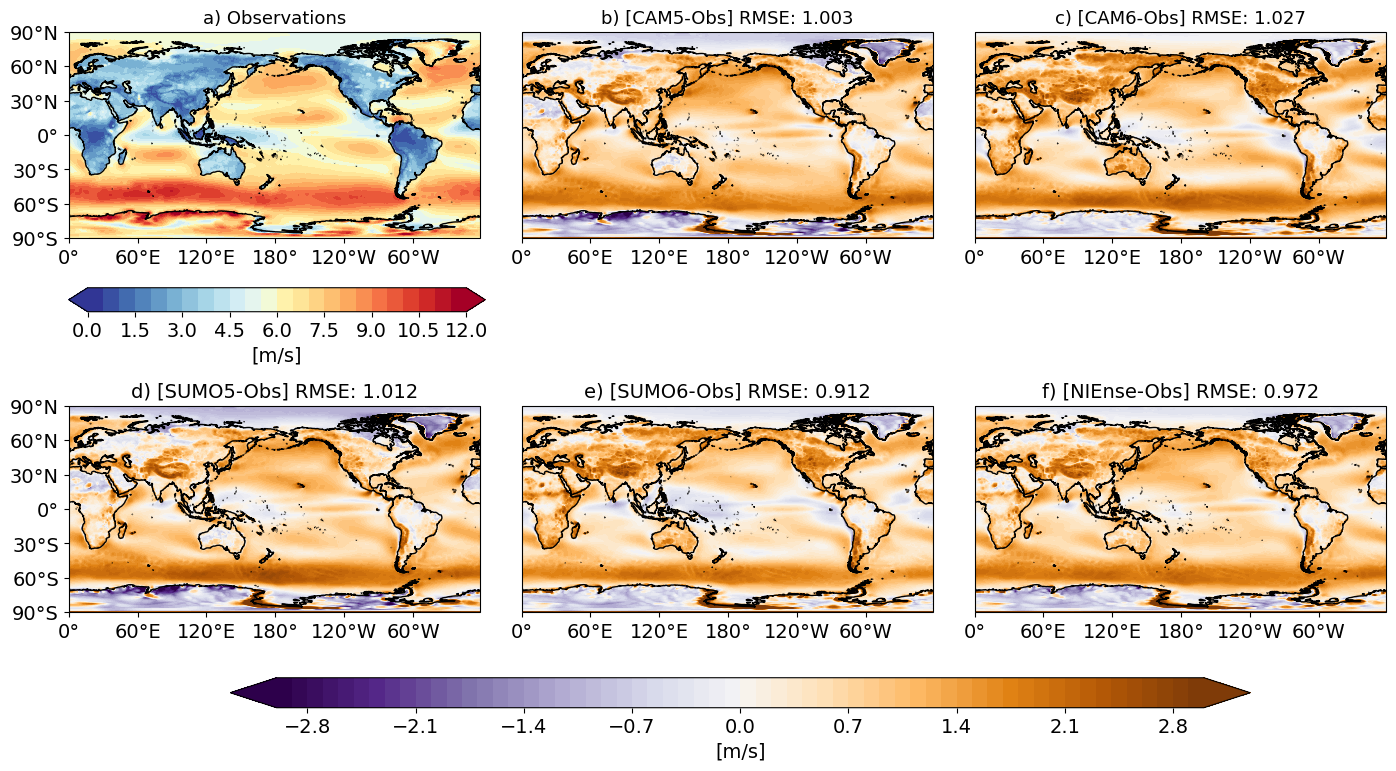

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.gridspec as gridspec

# Assuming DSobs_season, DSCAM6_season, DSsuper5_season, DSMME_Season are already defined datasets

clevs = np.arange(-3, 3.1, .1)
bluey = mpl.cm.get_cmap('PuOr_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
cmapzzz = ListedColormap(newcolors)

clevs_obs = np.arange(-0, 12.5, .5)
bluey_obs = mpl.cm.get_cmap('RdYlBu_r', len(clevs_obs))
newcolors_obs = bluey_obs(np.linspace(0, 1, len(clevs_obs)))
cmapzzz_obs = ListedColormap(newcolors_obs)
proj = ccrs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(17, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 2], width_ratios=[1, 1, 1], wspace=0.1, hspace=-.32)

# Top left panel for new data
ax_top_left = fig.add_subplot(gs[0, 0], projection=proj)
plotter_obs = DSobs_season['U10']

ax_top_left.coastlines('50m')
f_obs = ax_top_left.contourf(lons - 180, lats, plotter_obs, levels=clevs_obs, cmap=cmapzzz_obs, extend='both', transform=proj)
ax_top_left.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_left.xaxis.set_major_formatter(lon_formatter)
ax_top_left.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_left.yaxis.set_major_formatter(lat_formatter)
ax_top_left.set_title('a) Observations', fontsize=13)
ax_top_left.tick_params(labelsize=14)

# Top middle panel for observations
ax_top_middle = fig.add_subplot(gs[0, 1], projection=proj)
plotter = DSCAM5_Season['U10'] - DSobs_season['U10']
d_rmse = wgt_rmse(DSCAM5_Season['U10'], DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
frmse = np.round(d_rmse, 3)

ax_top_middle.coastlines('50m')
f_diff = ax_top_middle.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
ax_top_middle.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_middle.xaxis.set_major_formatter(lon_formatter)
ax_top_middle.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_middle.yaxis.set_major_formatter(lat_formatter)
ax_top_middle.set_title(f'b) [CAM5-Obs] RMSE: {frmse}', fontsize=13)
ax_top_middle.tick_params(labelsize=14)
ax_top_middle.set_yticks([])  # Hide y-axis ticks for other subplots


# Top middle panel for observations
ax_top_middle = fig.add_subplot(gs[0, 2], projection=proj)
plotter = DSCAM6_season['U10'] - DSobs_season['U10']
d_rmse = wgt_rmse(DSCAM6_season['U10'], DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
frmse = np.round(d_rmse, 3)

ax_top_middle.coastlines('50m')
f_diff = ax_top_middle.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
ax_top_middle.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_middle.xaxis.set_major_formatter(lon_formatter)
ax_top_middle.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_middle.yaxis.set_major_formatter(lat_formatter)
ax_top_middle.set_title(f'c) [CAM6-Obs] RMSE: {frmse}', fontsize=13)
ax_top_middle.tick_params(labelsize=14)
ax_top_middle.set_yticks([])  # Hide y-axis ticks for other subplots


# Bottom row panels for difference fields
axs = [fig.add_subplot(gs[1, i], projection=proj) for i in range(3)]
for i, ax in enumerate(axs):
    if i == 0:
        plotter = DSsuper5_season['U10'] - DSobs_season['U10']
        d_rmse = wgt_rmse(DSsuper5_season['U10'], DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
        
    elif i == 1:
        plotter = DSsuper6_season['U10'] - DSobs_season['U10']
        d_rmse = wgt_rmse(DSsuper6_season['U10'], DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
        
    elif i == 2:
        plotter = DSMME_Season['U10'] - DSobs_season['U10']
        d_rmse = wgt_rmse(DSMME_Season['U10'], DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
    
    ax.coastlines('50m')
    f_diff = ax.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
    ax.set_xticks(np.arange(-180, 180, 60))
    lon_formatter = LongitudeFormatter(number_format='.0f')
    ax.xaxis.set_major_formatter(lon_formatter)
    
    if i == 0:
        ax.set_yticks(np.arange(-90, 100, 30))
        lat_formatter = LatitudeFormatter(number_format='.0f')
        ax.yaxis.set_major_formatter(lat_formatter)
    else:
        ax.set_yticks([])  # Hide y-axis ticks for other subplots
    
    if i == 0:
        ax.set_title(f'd) [SUMO5-Obs] RMSE: {frmse}', fontsize=14)
    elif i == 1:
        ax.set_title(f'e) [SUMO6-Obs] RMSE: {frmse}', fontsize=14)
    elif i == 2:
        ax.set_title(f'f) [NIEnse-Obs] RMSE: {frmse}', fontsize=14)
    
    ax.tick_params(labelsize=14)

cbar_ax_diff = fig.add_axes([0.22, 0.25, 0.6, 0.025])  # [left, bottom, width, height] in figure coordinate
cbar_diff = fig.colorbar(f_diff, cax=cbar_ax_diff, orientation='horizontal')
cbar_diff.ax.tick_params(labelsize=14)
cbar_diff.set_label(label='[m/s]', fontsize=14)

cbar_ax_obs = fig.add_axes([0.125, 0.58, 0.245, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar_obs = fig.colorbar(f_obs, cax=cbar_ax_obs, orientation='horizontal')
cbar_obs.ax.tick_params(labelsize=14)
cbar_obs.set_label(label='[m/s]', fontsize=14)

plt.savefig(f'./{SEAS}_Bias_U10_NIense-Super56.png', bbox_inches='tight', dpi=400)
plt.show()


## Hi hi

/glade/derecho/scratch/wchapman/tmp/ipykernel_32705/3612228174.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey = mpl.cm.get_cmap('PuOr_r', len(clevs))
/glade/derecho/scratch/wchapman/tmp/ipykernel_32705/3612228174.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluey_obs = mpl.cm.get_cmap('RdYlBu_r', len(clevs_obs))


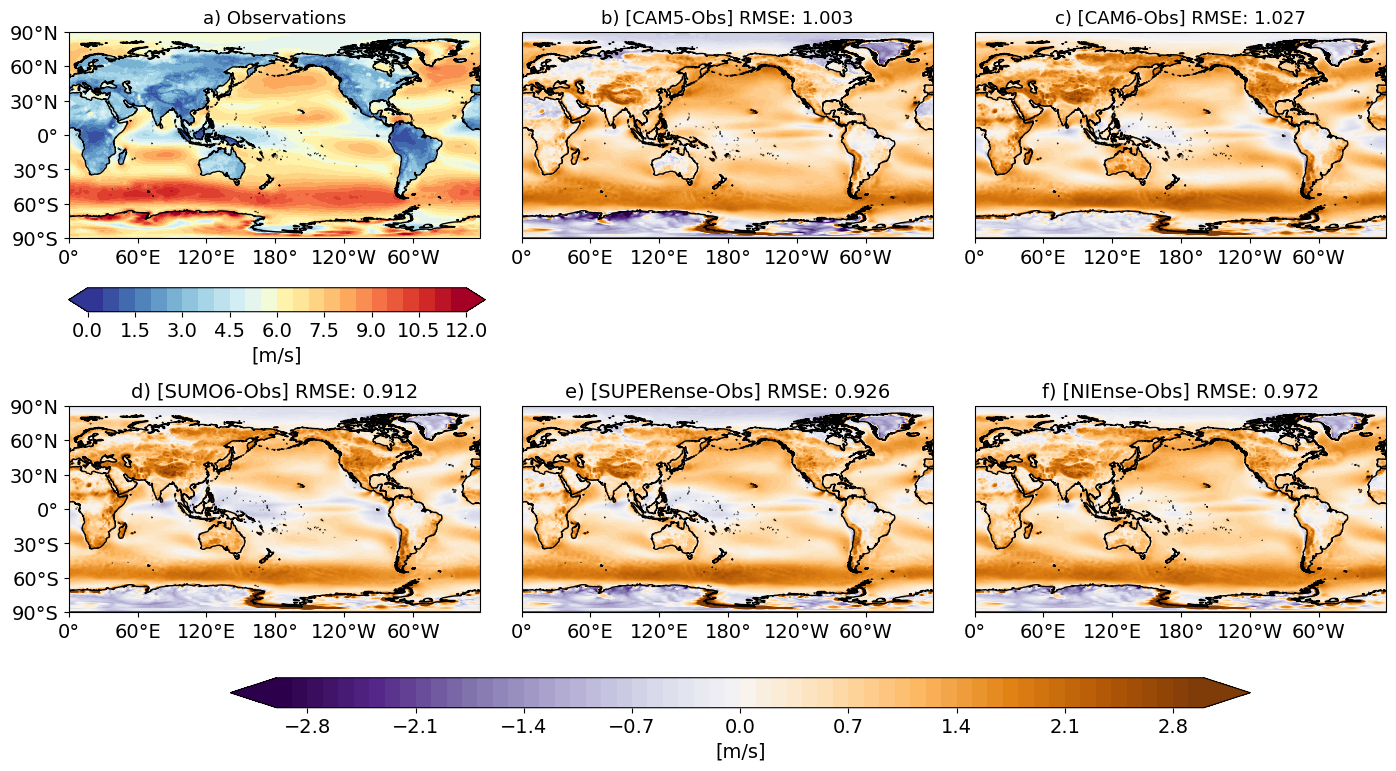

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.gridspec as gridspec

# Assuming DSobs_season, DSCAM6_season, DSsuper5_season, DSMME_Season are already defined datasets

clevs = np.arange(-3, 3.1, .1)
bluey = mpl.cm.get_cmap('PuOr_r', len(clevs))
newcolors = bluey(np.linspace(0, 1, len(clevs)))
cmapzzz = ListedColormap(newcolors)

clevs_obs = np.arange(-0, 12.5, .5)
bluey_obs = mpl.cm.get_cmap('RdYlBu_r', len(clevs_obs))
newcolors_obs = bluey_obs(np.linspace(0, 1, len(clevs_obs)))
cmapzzz_obs = ListedColormap(newcolors_obs)
proj = ccrs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(17, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 2], width_ratios=[1, 1, 1], wspace=0.1, hspace=-.32)

# Top left panel for new data
ax_top_left = fig.add_subplot(gs[0, 0], projection=proj)
plotter_obs = DSobs_season['U10']

ax_top_left.coastlines('50m')
f_obs = ax_top_left.contourf(lons - 180, lats, plotter_obs, levels=clevs_obs, cmap=cmapzzz_obs, extend='both', transform=proj)
ax_top_left.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_left.xaxis.set_major_formatter(lon_formatter)
ax_top_left.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_left.yaxis.set_major_formatter(lat_formatter)
ax_top_left.set_title('a) Observations', fontsize=13)
ax_top_left.tick_params(labelsize=14)

# Top middle panel for observations
ax_top_middle = fig.add_subplot(gs[0, 1], projection=proj)
plotter = DSCAM5_Season['U10'] - DSobs_season['U10']
d_rmse = wgt_rmse(DSCAM5_Season['U10'], DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
frmse = np.round(d_rmse, 3)

ax_top_middle.coastlines('50m')
f_diff = ax_top_middle.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
ax_top_middle.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_middle.xaxis.set_major_formatter(lon_formatter)
ax_top_middle.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_middle.yaxis.set_major_formatter(lat_formatter)
ax_top_middle.set_title(f'b) [CAM5-Obs] RMSE: {frmse}', fontsize=13)
ax_top_middle.tick_params(labelsize=14)
ax_top_middle.set_yticks([])  # Hide y-axis ticks for other subplots


# Top middle panel for observations
ax_top_middle = fig.add_subplot(gs[0, 2], projection=proj)
plotter = DSCAM6_season['U10'] - DSobs_season['U10']
d_rmse = wgt_rmse(DSCAM6_season['U10'], DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
frmse = np.round(d_rmse, 3)

ax_top_middle.coastlines('50m')
f_diff = ax_top_middle.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
ax_top_middle.set_xticks(np.arange(-180, 180, 60))
lon_formatter = LongitudeFormatter(number_format='.0f')
ax_top_middle.xaxis.set_major_formatter(lon_formatter)
ax_top_middle.set_yticks(np.arange(-90, 100, 30))
lat_formatter = LatitudeFormatter(number_format='.0f')
ax_top_middle.yaxis.set_major_formatter(lat_formatter)
ax_top_middle.set_title(f'c) [CAM6-Obs] RMSE: {frmse}', fontsize=13)
ax_top_middle.tick_params(labelsize=14)
ax_top_middle.set_yticks([])  # Hide y-axis ticks for other subplots


# Bottom row panels for difference fields
axs = [fig.add_subplot(gs[1, i], projection=proj) for i in range(3)]
for i, ax in enumerate(axs):
    if i == 0:
        plotter = DSsuper6_season['U10'] - DSobs_season['U10']
        d_rmse = wgt_rmse(DSsuper6_season['U10'], DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
        
    elif i == 1:
        # plotter = DSsuper5_season['U10'] - DSobs_season['U10']
        plotter = DSMMEr_season['U10'] - DSobs_season['U10']
        d_rmse = wgt_rmse(DSMMEr_season['U10'], DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
        
    elif i == 2:
        plotter = DSMME_Season['U10'] - DSobs_season['U10']
        d_rmse = wgt_rmse(DSMME_Season['U10'], DSobs_season['U10'], wgt)  # correct weighted RMSE for (lat,lon) fields.
        frmse = np.round(d_rmse, 3)
    
    ax.coastlines('50m')
    f_diff = ax.contourf(lons - 180, lats, plotter, levels=clevs, cmap=cmapzzz, extend='both', transform=proj)
    ax.set_xticks(np.arange(-180, 180, 60))
    lon_formatter = LongitudeFormatter(number_format='.0f')
    ax.xaxis.set_major_formatter(lon_formatter)
    
    if i == 0:
        ax.set_yticks(np.arange(-90, 100, 30))
        lat_formatter = LatitudeFormatter(number_format='.0f')
        ax.yaxis.set_major_formatter(lat_formatter)
    else:
        ax.set_yticks([])  # Hide y-axis ticks for other subplots
    
    if i == 0:
        ax.set_title(f'd) [SUMO6-Obs] RMSE: {frmse}', fontsize=14)
    elif i == 1:
        ax.set_title(f'e) [SUPERense-Obs] RMSE: {frmse}', fontsize=14)
    elif i == 2:
        ax.set_title(f'f) [NIEnse-Obs] RMSE: {frmse}', fontsize=14)
    
    ax.tick_params(labelsize=14)

cbar_ax_diff = fig.add_axes([0.22, 0.25, 0.6, 0.025])  # [left, bottom, width, height] in figure coordinate
cbar_diff = fig.colorbar(f_diff, cax=cbar_ax_diff, orientation='horizontal')
cbar_diff.ax.tick_params(labelsize=14)
cbar_diff.set_label(label='[m/s]', fontsize=14)

cbar_ax_obs = fig.add_axes([0.125, 0.58, 0.245, 0.02])  # [left, bottom, width, height] in figure coordinate
cbar_obs = fig.colorbar(f_obs, cax=cbar_ax_obs, orientation='horizontal')
cbar_obs.ax.tick_params(labelsize=14)
cbar_obs.set_label(label='[m/s]', fontsize=14)

plt.savefig(f'./{SEAS}_Bias_U10_NIense-SuperENSE.png', bbox_inches='tight', dpi=400)
plt.show()


## Is U10 Synchonized? 

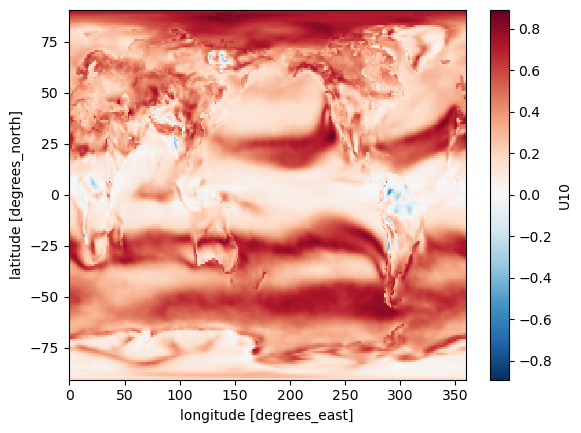

In [54]:
DSsuper6ts1 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/CAM6_Betzy1/ts/CAM6_Betzy1.cam.h0.U10.197901-200512.nc')
# DSsuper6_season = seas_mean(DSsuper6,df,SEAS)*86400000
DSsuper5ts = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/CAM5_Betzy1/ts/CAM5_Betzy1.cam.h0.U10.197901-200512.nc')
# DSsuper5_season = seas_mean(DSsuper6,df,SEAS)*86400000
correlationsuper = xr.corr(DSsuper6ts1['U10'], DSsuper5ts['U10'], dim='time')


DSsuper6ts1 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/CAM6_Betzy1/ts/CAM6_Betzy1.cam.h0.U10.197901-200512.nc')
# DSsuper6_season = seas_mean(DSsuper6,df,SEAS)*86400000
DSsuper5ts1 = xr.open_dataset('/glade/derecho/scratch/wchapman/ADF/FHIST_f09_g16//ts/FHIST_f09_g16.cam.h0.U10.197901-200512.nc')
correlationnon = xr.corr(DSsuper6ts1['U10'], DSsuper5ts1['U10'], dim='time')

(correlationsuper-correlationnon).plot()
plt.show() 